# Expectation Maximisation

In this problem, $g(x; \nu, \mu_1, \sigma_1)$, $x \in \mathbb{R}$, for $\nu > 0$, $\mu_1 \in \mathbb{R}$, and $\sigma_1 > 0$, denotes the probability density function (pdf) of the random variable

$$
X := \mu_1 + \sigma_1 Z,
$$

where $Z$ is a random variable that follows the Student $t$ distribution with $\nu$ degrees of freedom. As in lectures, we moreover denote by $\phi(x; \mu_2, \sigma_2)$ the pdf of the normal distribution with mean $\mu_2 \in \mathbb{R}$ and standard deviation $\sigma_2 > 0$.

(a) Generate a data set of $1000$ independent samples from $g(\cdot; 3, 5, 1)$. Fit then the pdf $g(x; \nu, \mu_1, \sigma_1)$ to the data using maximum likelihood.

(b) Formulate an expectation–maximisation (EM) algorithm to estimate the mixture pdf

$$
h(x) := h(x; \nu, \mu_1, \sigma_1, \mu_2, \sigma_2, \pi) := \pi g(x; \nu, \mu_1, \sigma_1) + (1 - \pi) \phi(x; \mu_2, \sigma_2), \quad x \in \mathbb{R}.
$$

*Hint:* Adapt the EM algorithm for the Gaussian mixture model (no need to derive the algorithm from first principles).

(c) Generate $1000$ independent samples from $\phi(\cdot; -3, 1.5)$ and merge them with the samples generated in (a). Implement the EM algorithm derived in (b), and use the algorithm to fit the mixture model to the combined data set. Is the algorithm able to identify the Student $t$ and Gaussian components correctly?

Before proceeding, we note the following about the random variable $X$.

We have that

$$
X = \mu_1 + \sigma_1 Z.
$$

Since $Z \sim t (\nu)$, by elementary properties of the $t$ distribution,

$$
X \sim t (\nu, \mu_1, \sigma_1).
$$

The log-likelihood function is given by

$$
l(\nu, \mu_1, \sigma_1) = \sum_{i=1}^n \log g ( x_i ; \nu, \mu_1, \sigma_1 ),
$$

where $g ( x_i ; \nu, \mu_1, \sigma_1 )$ is probability density function (pdf) of $X$.

## (a)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, norm
from scipy.optimize import minimize

In [2]:
# True parameters
nu_true = 3
mu1_true = 5
sigma1_true = 1

# Generate a data set of 1000 independent samples from g(·; 3, 5, 1)
X_t = t.rvs(df=nu_true, loc=mu1_true, scale=sigma1_true, size=1000, random_state=1)

In [3]:
def negative_log_likelihood(params, x):
    '''Function to return the negative log-likelihood for the Student t distribution
    given params [nu, mu1, sigma1] and data.'''
    nu, mu1, sigma1 = params
    negative_log_likelihood = -np.sum(t.logpdf(x, df=nu, loc=mu1, scale=sigma1))
    return negative_log_likelihood

# Initial guess of parameters for minimisation
# NOTE: I have introduced a degree of randomness to ensure the minimisation works as intended
initial_params = [nu_true + np.random.uniform(-1, 1),
                  mu1_true + np.random.uniform(-1, 1),
                  sigma1_true + np.random.uniform(-1, 1)]

# Minimise the negative log-likelihood
result = minimize(negative_log_likelihood, initial_params, args=(X_t), bounds=[(1e-5, None), (None, None), (1e-5, None)])
nu_est, mu1_est, sigma1_est = result.x

print(f'Estimated parameter values:\nnu = {nu_est:.2f}\nmu1 = {mu1_est:.2f}\nsigma1 = {sigma1_est:.2f}')

Estimated parameter values:
nu = 3.43
mu1 = 5.06
sigma1 = 1.05


## (b)

I will express my expectation–maximisation (EM) algorithm in the form of pseudocode.

$\texttt{initialise estimate of pi as 0.5}$

$\texttt{initialise estimates of nu, mu1, sigma1, mu2, sigma2 as true values + random number}$

$\texttt{while not reached niter:}$

$\texttt{\quad compute responsibilities}$

$\texttt{\quad update pi via pi[i+1] = mean(resp)}$

$\texttt{\quad update mu1 via mu1[i+1] = sum(resp * x) / sum(resp)}$

$\texttt{\quad update nu, sigma1 by minimising the negative log-likelihood w.r.t. nu, sigma1}$

$\texttt{\quad update mu2 via mu2[i+1] = sum((1 - resp) * x) / sum(1 - resp)}$

$\texttt{\quad update sigma2 via sigma2[i+1] = sqrt(sum((1 - resp) * (x - mu2[i+1])**2) / sum(1 - resp))}$

## (c)

In [4]:
mu2_true = -3
sigma2_true = 1.5

# Generate 1000 independent samples from phi(·; -3, 1.5)
X_n = norm.rvs(loc=mu2_true, scale=sigma2_true, size=1000, random_state=1)

# Merge with the samples generated in (a)
X_combined = np.concatenate([X_t, X_n])

In [5]:
# Implement the EM algorithm derived in (b)

def negative_log_likelihood_updated(nu_sigma1, x, mu1, resp):
    '''Function to return the negative log-likelihood for the Student t distribution
    given nu_sigma1 [nu, sigma1], x, mu1 and resp in the appropriate format for use
    in mixture_em.'''
    nu, sigma1 = nu_sigma1
    negative_log_likelihood = -np.sum(resp * t.logpdf(x, df=nu, loc=mu1, scale=sigma1))
    return negative_log_likelihood

def mixture_em(x, niter=100):
    '''Function to perform the expectation–maximisation (EM) algorithm to estimate the
    mixture pdf h(x; nu, mu1, sigma1, mu2, sigma2, pi).'''
    # Initialise parameter estimates
    pi, mu1, mu2, sigma1, sigma2, nu = [np.zeros(niter + 1) for _ in range(6)]
    pi[0] = 0.5
    nu[0] = nu_true + np.random.uniform(-1, 1)
    mu1[0] = mu1_true + np.random.uniform(-1, 1)
    sigma1[0] = sigma1_true + np.random.uniform(-1, 1)
    mu2[0] = mu2_true + np.random.uniform(-1, 1)
    sigma2[0] = sigma2_true + np.random.uniform(-1, 1)

    for i in range(niter):
        # Expectation (compute responsibilities)
        resp = pi[i] * t.pdf(x, df=nu[i], loc=mu1[i], scale=sigma1[i]) / \
               (pi[i] * t.pdf(x, df=nu[i], loc=mu1[i], scale=sigma1[i]) +
                (1 - pi[i]) * norm.pdf(x, loc=mu2[i], scale=sigma2[i]))

        # Maximisation (update parameters)
        pi[i+1] = np.mean(resp)

        mu1[i+1] = np.sum(resp * x) / np.sum(resp)
        result = minimize(negative_log_likelihood_updated, [nu[i], sigma1[i]], args=(x, mu1[i+1], resp), bounds=[(1e-5, None), (1e-5, None)])
        nu[i+1], sigma1[i+1] = result.x

        mu2[i+1] = np.sum((1 - resp) * x) / np.sum(1 - resp)
        sigma2[i+1] = np.sqrt(np.sum((1 - resp) * (x - mu2[i+1])**2) / np.sum(1 - resp))

    return pi, nu, mu1, sigma1, mu2, sigma2

In [6]:
# Use the algorithm to fit the mixture model to the combined data set
EM_fit = mixture_em(X_combined)

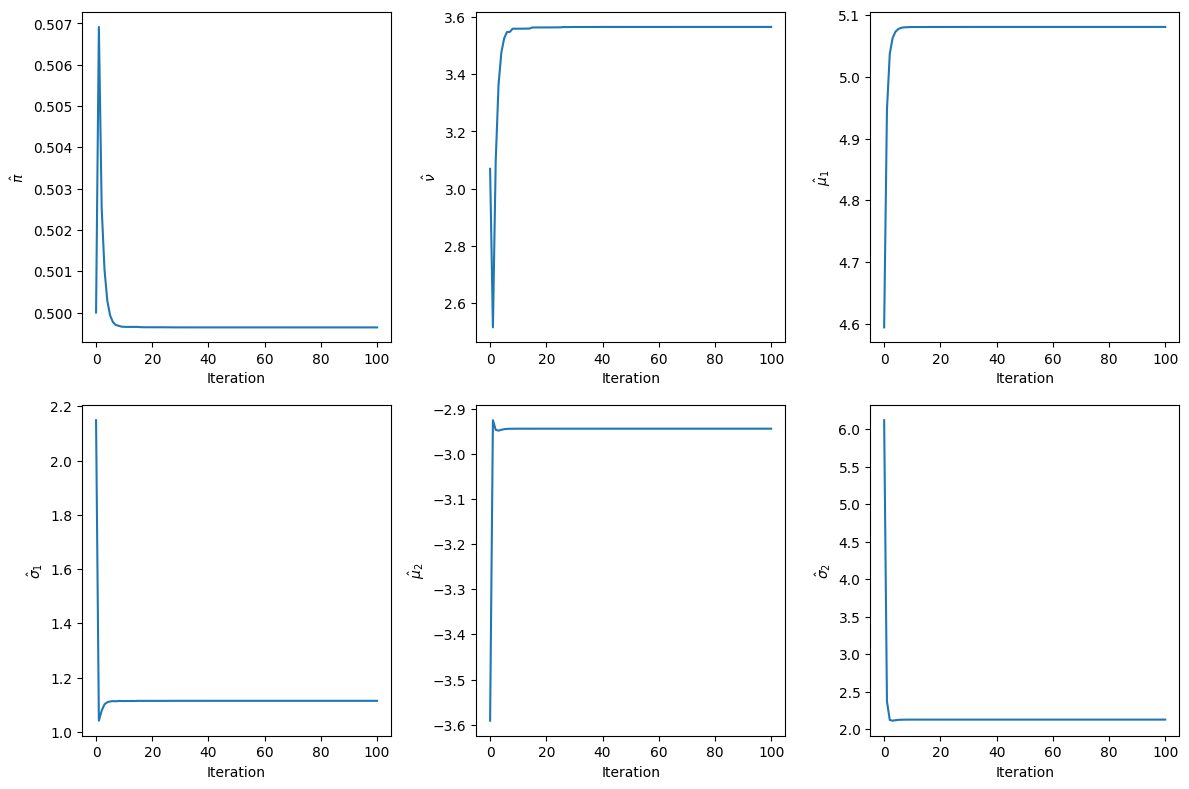

In [7]:
# Plot the histories to assess convergence
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

axs[0, 0].plot(EM_fit[0])
axs[0, 0].set_ylabel(r'$\hat{\pi}$')
axs[0, 0].set_xlabel('Iteration')

axs[0, 1].plot(EM_fit[1])
axs[0, 1].set_ylabel(r'$\hat{\nu}$')
axs[0, 1].set_xlabel('Iteration')

axs[0, 2].plot(EM_fit[2])
axs[0, 2].set_ylabel(r'$\hat{\mu}_1$')
axs[0, 2].set_xlabel('Iteration')

axs[1, 0].plot(np.square(EM_fit[3]))
axs[1, 0].set_ylabel(r'$\hat{\sigma}_1$')
axs[1, 0].set_xlabel('Iteration')

axs[1, 1].plot(EM_fit[4])
axs[1, 1].set_ylabel(r'$\hat{\mu}_2$')
axs[1, 1].set_xlabel('Iteration')

axs[1, 2].plot(np.square(EM_fit[5]))
axs[1, 2].set_ylabel(r'$\hat{\sigma}_2$')
axs[1, 2].set_xlabel('Iteration')

plt.tight_layout()
plt.show()

In [8]:
# Estimated values of the parameters
estimated_params = {
    'pi': EM_fit[0][-1],
    'nu': EM_fit[1][-1],
    'mu1': EM_fit[2][-1],
    'sigma1': EM_fit[3][-1],
    'mu2': EM_fit[4][-1],
    'sigma2': EM_fit[5][-1]
}

print('Estimated parameter values:')
for param, value in estimated_params.items():
    print(f'{param}: {value:.2f}')

Estimated parameter values:
pi: 0.50
nu: 3.57
mu1: 5.08
sigma1: 1.06
mu2: -2.94
sigma2: 1.46


The algorithm performs very well for $\pi$, $\mu_1$, $\sigma_1$, $\mu_2$, $\sigma_2$ and performs relatively well for $\nu$. To investigate this further, we can repeat with $100$ times the number of samples.

In [9]:
X_t = t.rvs(df=nu_true, loc=mu1_true, scale=sigma1_true, size=100000, random_state=1)
X_n = norm.rvs(loc=mu2_true, scale=sigma2_true, size=100000, random_state=1)
X_combined = np.concatenate([X_t, X_n])

EM_fit = mixture_em(X_combined)

estimated_params = {
    'pi': EM_fit[0][-1],
    'nu': EM_fit[1][-1],
    'mu1': EM_fit[2][-1],
    'sigma1': EM_fit[3][-1],
    'mu2': EM_fit[4][-1],
    'sigma2': EM_fit[5][-1]
}

print('Estimated parameter values:')
for param, value in estimated_params.items():
    print(f'{param}: {value:.2f}')

Estimated parameter values:
pi: 0.50
nu: 3.01
mu1: 5.00
sigma1: 1.00
mu2: -2.99
sigma2: 1.50


With $100$ times the number of samples, we see that the parameter estimates have all converged to their true values. This shows that the estimate of $\nu$ obtained using fewer samples is either a nuance of the randomly generated data, or is because $\nu$ is a less stable parameter.